## Initialization

In [1]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
EXEC_PATH = "C:\opt\ibm\ILOG\CPLEX_Studio2211\cplex\bin\x64_win64\cplex.exe"


In [3]:
model = pyo.ConcreteModel()


## Data

In [4]:
#data
data = pd.read_excel('Dados_DEEC.xlsx', None)
i = len(data['EV']['E_max'].tolist())
t = len(data['Price']['C_IG'].tolist())
delta_t = 0.25
P_ch_max = 10
P_dch_max = 10
C_IG = data['Price']['C_IG'].tolist()
C_EG = data['Price']['C_EG'].tolist()
L_plus = data['Price']['L_plus'].tolist()
L_min = data['Price']['L_min'].tolist()
E_max = data['EV']['E_max'].tolist()
E_min = data['EV']['E_min'].tolist()
E_dep = data['EV']['E_dep'].tolist()
T_arv = data['EV']['T_arv'].tolist()
T_dep = data['EV']['T_dep'].tolist()

## Sets

In [5]:
model.I = pyo.RangeSet(i) #index of the vehicles i parked
#out of use due to undetermined number of chargers model.N = pyo.RangeSet(n) #index of the chargers installed (not used at the moment)
model.T = pyo.RangeSet(t) #index of the time periods (min)

## Parameters

In [6]:
model.C_IG = pyo.Param(model.T, initialize=lambda model, t: C_IG[t-1])
model.C_EG = pyo.Param(model.T, initialize=lambda model, t: C_EG[t-1])
model.L_plus = pyo.Param(model.T, initialize=lambda model, t: L_plus[t-1])
model.L_min = pyo.Param(model.T, initialize=lambda model, t: L_min[t-1])
model.E_dep = pyo.Param(model.I, initialize=lambda model, i: E_dep[i-1])
model.E_max = pyo.Param(model.I, initialize=lambda model, i:E_max[i-1])
model.E_min = pyo.Param(model.I, initialize=lambda model, i:E_min[i-1])
model.P_ch_max = pyo.Param(initialize=P_ch_max)
model.P_dch_max = pyo.Param(initialize=P_dch_max)
model.T_arv = pyo.Param(model.I, initialize=lambda model, i: T_arv[i-1])
model.T_dep = pyo.Param(model.I, initialize=lambda model, i: T_dep[i-1])
model.delta_t = pyo.Param(initialize=delta_t)



## Variables

In [7]:
#Binary variables
model.x = pyo.Var(model.I, model.T, domain=pyo.Binary)
model.y = pyo.Var(model.I, model.T, domain=pyo.Binary)

#Non-binary variables
model.e = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)
model.p_ch_ev = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)
model.p_dch_ev = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)
model.p_ev_plus = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.p_ev_minus = pyo.Var(model.T, domain=pyo.NonNegativeReals)


## Constraints

In [8]:
model.constraints = pyo.ConstraintList()

#Constraint 1
for i in model.I:
    for t in model.T:
        model.constraints.add(model.x[i,t]+model.y[i,t]==1)

#Constraint 2
for t in model.T:
    model.constraints.add(sum(model.delta_t*model.P_ch_max*model.x[i,t] for i in model.I)==model.p_ev_plus[t])

#Constraint 3
for t in model.T:
    model.constraints.add(sum(model.delta_t*model.P_dch_max*model.y[i,t] for i in model.I)==model.p_ev_minus[t])

#Constraint 4
for i in model.I:
    for t in range(model.T_arv[i], model.T_dep[i]-1):
        model.constraints.add(model.e[i,t+1] == model.e[i,t] + model.delta_t*(model.P_ch_max*model.x[i,t] - model.P_dch_max*model.y[i,t]))

#Constraint 5
for i in model.I:
        model.constraints.add(model.e[i,model.T_dep[i]]==model.E_dep[i])

#Constraint 6
for i in model.I:
    for t in model.T:
        model.constraints.add(model.E_min[i] <= model.e[i,t])
        model.constraints.add(model.e[i,t] <= model.E_max[i])

'''
#Constraint 7
for i in model.I:
    model.constraints.add(0 <= model.p_ch_ev[i,t])
    model.constraints.add(model.p_ch_ev[i,t] <= model.P_ch_max)

for t in model.T:
    model.constraints.add(0 <= model.p_ch_ev[i,t])
    model.constraints.add(model.p_ch_ev[i,t] <= model.P_ch_max)

#Constraint 8
for i in model.I:
    model.constraints.add(0 <= model.p_dch_ev[i,t])
    model.constraints.add(model.p_dch_ev[i,t] <= model.P_dch_max)

for t in model.T:
    model.constraints.add(0 <= model.p_dch_ev[i,t])
    model.constraints.add(model.p_dch_ev[i,t] <= model.P_dch_max)
'''

'\n#Constraint 7\nfor i in model.I:\n    model.constraints.add(0 <= model.p_ch_ev[i,t])\n    model.constraints.add(model.p_ch_ev[i,t] <= model.P_ch_max)\n\nfor t in model.T:\n    model.constraints.add(0 <= model.p_ch_ev[i,t])\n    model.constraints.add(model.p_ch_ev[i,t] <= model.P_ch_max)\n\n#Constraint 8\nfor i in model.I:\n    model.constraints.add(0 <= model.p_dch_ev[i,t])\n    model.constraints.add(model.p_dch_ev[i,t] <= model.P_dch_max)\n\nfor t in model.T:\n    model.constraints.add(0 <= model.p_dch_ev[i,t])\n    model.constraints.add(model.p_dch_ev[i,t] <= model.P_dch_max)\n'

## Objective Function

In [9]:
def rule_obj(mod):
    return mod.delta_t*sum(mod.C_IG[t]*(mod.L_plus[t]+mod.p_ev_plus[t]) - mod.C_EG[t]*(mod.L_min[t]+mod.p_ev_minus[t])for t in mod.T)
model.obj = pyo.Objective(rule = rule_obj, sense = pyo.minimize)

## Solvers

In [10]:
# Create a solver instance and set executable path
opt = pyo.SolverFactory('cplex')
# Solve the model
results = opt.solve(model, tee=False)
# Print solution status
print(model.obj())

190.05017816887712


In [11]:
def car_energy(I,T,e):
    car_list = []
    energy_list = []
    for i in I:
        car_number = 'car' + ' ' + str(i)
        car_list.append(car_number)
    for i in I:
        for t in T:
            energy_list.append(pyo.value(e[i,t]))
    energy_array = np.reshape(energy_list, (len(T), len(car_list)))
    Energy = pd.DataFrame(energy_array, index=T, columns=car_list)
    return Energy

Text(0, 0.5, 'Energy [kWh]')

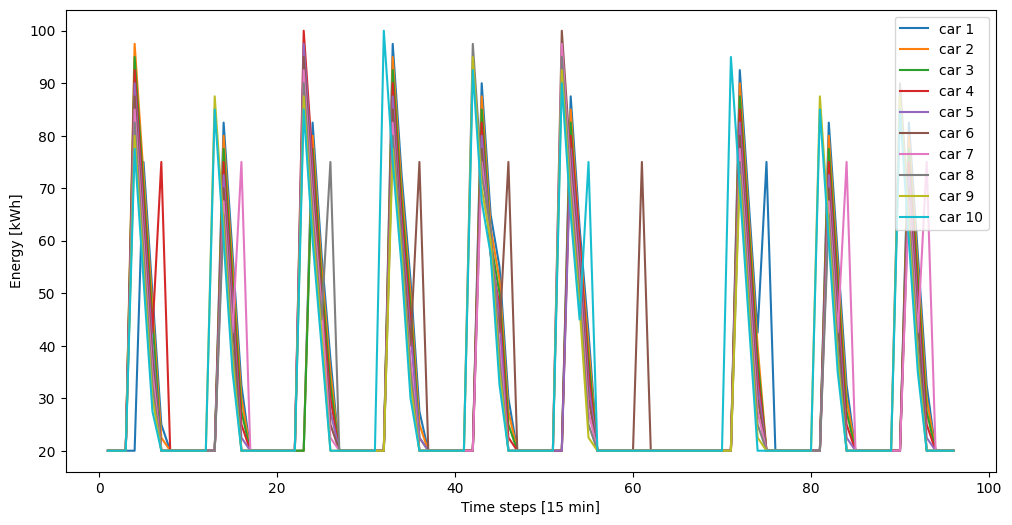

In [12]:
Energy = car_energy(model.I,model.T,model.e)
Energy.plot(figsize=(12,6))
plt.xlabel('Time steps [15 min]')
plt.ylabel('Energy [kWh]')